In [1]:
import tensorrt
import pandas as pd
import tensorflow as tf
import numpy as np
import argparse
import importlib  
from keras.optimizers import Adam
import os
import time
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib
from utils.keras_functions import sparse_crossentropy_ignoring_last_label, Jaccard
import Keras_segmentation_deeplab_v3_1.utils
from tensorflow.python.compiler.tensorrt import trt_convert as trt


keras_deeplab = importlib.import_module("keras-deeplab-v3-plus.model")

image_size = (375,513)

losses = sparse_crossentropy_ignoring_last_label
metrics = {'pred_mask' : [Jaccard]}


def build_model(model_name, os, alpha, norm):
    try:
        deeplab_model = keras_deeplab.Deeplabv3(backbone=model_name, input_shape=(375, 513, 3), classes=19, weights='cityscapes', OS=os, alpha=alpha, infer=True, normalization=norm)
    except:
        raise Exception("No model with given backbone: ", model_name)

    deeplab_model.compile(optimizer = Adam(lr=7e-4, epsilon=1e-8, decay=1e-6), sample_weight_mode = "temporal",
              loss = losses, metrics = metrics)
    return deeplab_model

def load_model(path):
    deeplab_model = keras_deeplab.Deeplabv3(backbone='xception', input_shape=(375, 513, 3), classes=19, weights='cityscapes', OS=16, alpha=1, infer=True, normalization=0)
    deeplab_model.load_weights(path)

    return deeplab_model

Version 2.x.x


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9042291985393255099
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7787577344
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17317329462616085683
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:06:00.0, compute capability: 8.6"
]


In [3]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

model = load_model('/mnt/7BCDA59C6DEFFE3C/kitti_weights/xception_retrained_375_0001_rndcrop_infinite/xception_retrained_375_0001_rndcrop_infinite_model.21-0.27-0.53.h5')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6
Cityscapes!


In [60]:
model.summary()

Model: "deeplabv3plus"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 375, 513, 3) 0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 375, 513, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
entry_flow_conv1_1 (Conv2D)     (None, 188, 257, 32) 864         lambda_12[0][0]                  
__________________________________________________________________________________________________
entry_flow_conv1_1_BN (BatchNor (None, 188, 257, 32) 128         entry_flow_conv1_1[0][0]         
______________________________________________________________________________________

In [4]:
SegClass = Keras_segmentation_deeplab_v3_1.utils.SegModel("../kitti360_dataset_truncated.csv", image_size=image_size)

test_generator = SegClass.create_generators(dataset = "../kitti360_dataset_truncated.csv", blur=0, mode='test',
                                                n_classes=19, horizontal_flip=False, vertical_flip=False, 
                                                brightness=0, rotation=False, zoom=0, batch_size=4,
                                                seed=7, do_ahisteq=False, resize_shape=(375,513))

In [5]:
options = tf.profiler.experimental.ProfilerOptions(host_tracer_level = 3,
                                            python_tracer_level = 1,
                                            device_tracer_level = 1)

In [6]:
x,y = test_generator.__getitem__(0)

In [64]:
#tf.profiler.experimental.start('logdir_profiler/keras', options)
t0 = time.time()
y_keras = model.predict(x)
t1 = time.time()
#tf.profiler.experimental.stop()
print('Keras time', t1 - t0)

Keras time 0.09475135803222656


(4, 375, 513)
[[8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 ...
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]]
(192375, 1)
[[8 8 8 ... 2 2 2]
 [8 8 8 ... 2 2 2]
 [8 8 8 ... 2 2 2]
 ...
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]]


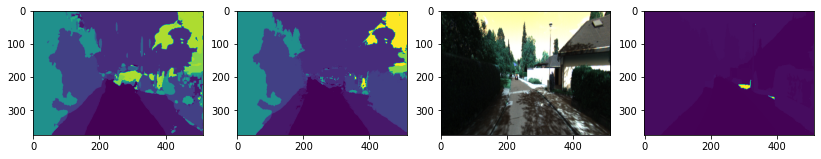

In [65]:
import numpy as np
import matplotlib.pyplot as plt

res = np.argmax(y_keras, -1)
print(res.shape)
print(res[0])

plt.figure(figsize=(14,10))
plt.subplot(141)
plt.imshow(res[0].astype('uint8'))
MAP = Keras_segmentation_deeplab_v3_1.utils.do_crf(x[0], res[0], zero_unsure=False)
plt.subplot(142)
plt.imshow(MAP.astype('uint8'))
plt.subplot(143)
plt.imshow(x[0].astype('int32'))
plt.subplot(144)
plt.imshow(y[0].reshape(image_size).astype('uint8'))
print(y[0].shape)
print(y[0].reshape(image_size))

In [66]:
model.save('pb_files/xception_freezed_mixed_attempt/')

INFO:tensorflow:Assets written to: pb_files/xception_freezed_mixed_attempt/assets


In [9]:
print('Converting to TF-TRT FP16...')
conversion_params = tf.experimental.tensorrt.ConversionParams(precision_mode='FP16', max_workspace_size_bytes=(1<<25))

converter = trt.TrtGraphConverterV2(input_saved_model_dir='pb_files/xception_freezed_mixed_attempt/', conversion_params=conversion_params)
converter.convert()

Converting to TF-TRT FP16...
INFO:tensorflow:Linked TensorRT version: (7, 2, 2)
INFO:tensorflow:Loaded TensorRT version: (7, 2, 3)
INFO:tensorflow:Loaded TensorRT 7.2.3 and linked TensorFlow against TensorRT 7.2.2. This is supported because TensorRT  minor/patch upgrades are backward compatible


<ConcreteFunction pruned(input_3) at 0x7FF5EB36D100>

In [12]:
def in_func():
    input_sizes = [[375, 513]]
    for size in input_sizes:
        inp1 = np.random.normal(size=(1, *size, 3)).astype(np.float32)
        yield [inp1]

converter.build(input_fn=in_func)

In [13]:
converter.save(output_saved_model_dir='converted_trt/xception_freezed_FP16/')
print('Done Converting to TF-TRT FP16')

INFO:tensorflow:Assets written to: converted_trt/xception_freezed_FP16/assets
Done Converting to TF-TRT FP16


In [14]:
from tensorflow.python.saved_model import tag_constants

"""Runs prediction on a single image and shows the result.
input_saved_model (string): Name of the input model stored in the current dir
"""

inp = tf.constant(x)

saved_model_loaded = tf.saved_model.load('converted_trt/xception_freezed_FP16/', tags=[tag_constants.SERVING])
signature_keys = list(saved_model_loaded.signatures.keys())
print(signature_keys)

infer = saved_model_loaded.signatures['serving_default']
print(infer.structured_outputs)

['serving_default']
{'lambda_17': TensorSpec(shape=<unknown>, dtype=tf.float32, name='lambda_17')}


In [16]:
#tf.profiler.experimental.start('logdir_profiler/tensorrt_FP16_2', options)
t0 = time.time()
labeling = infer(inp)
t1 = time.time()
#tf.profiler.experimental.stop()
print('TensorRT time', t1 - t0)

TensorRT time 0.0200040340423584


(4, 375, 513)
[[8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 [8 8 8 ... 8 8 8]
 ...
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]]
(192375, 1)
[[8 8 8 ... 2 2 2]
 [8 8 8 ... 2 2 2]
 [8 8 8 ... 2 2 2]
 ...
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]
 [8 8 8 ... 1 1 1]]


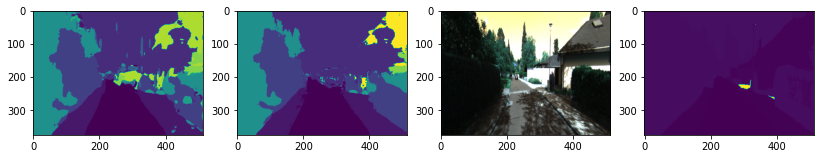

In [27]:
res = np.argmax(labeling['lambda_5'].numpy(), -1)
print(res.shape)
print(res[0])

plt.figure(figsize=(14,10))
plt.subplot(141)
plt.imshow(res[0].astype('uint8'))
MAP = Keras_segmentation_deeplab_v3_1.utils.do_crf(x[0], res[0], zero_unsure=False)
plt.subplot(142)
plt.imshow(MAP.astype('uint8'))
plt.subplot(143)
plt.imshow(x[0].astype('int32'))
plt.subplot(144)
plt.imshow(y[0].reshape(image_size).astype('uint8'))
print(y[0].shape)
print(y[0].reshape(image_size))